# Important imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_auc_score, roc_curve, auc


# Loading  and exploring the data

In [2]:
df = pd.read_csv('../Processed_data/Thyroid_Diff.csv',sep=',')
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


## Calculate the correlation matrix

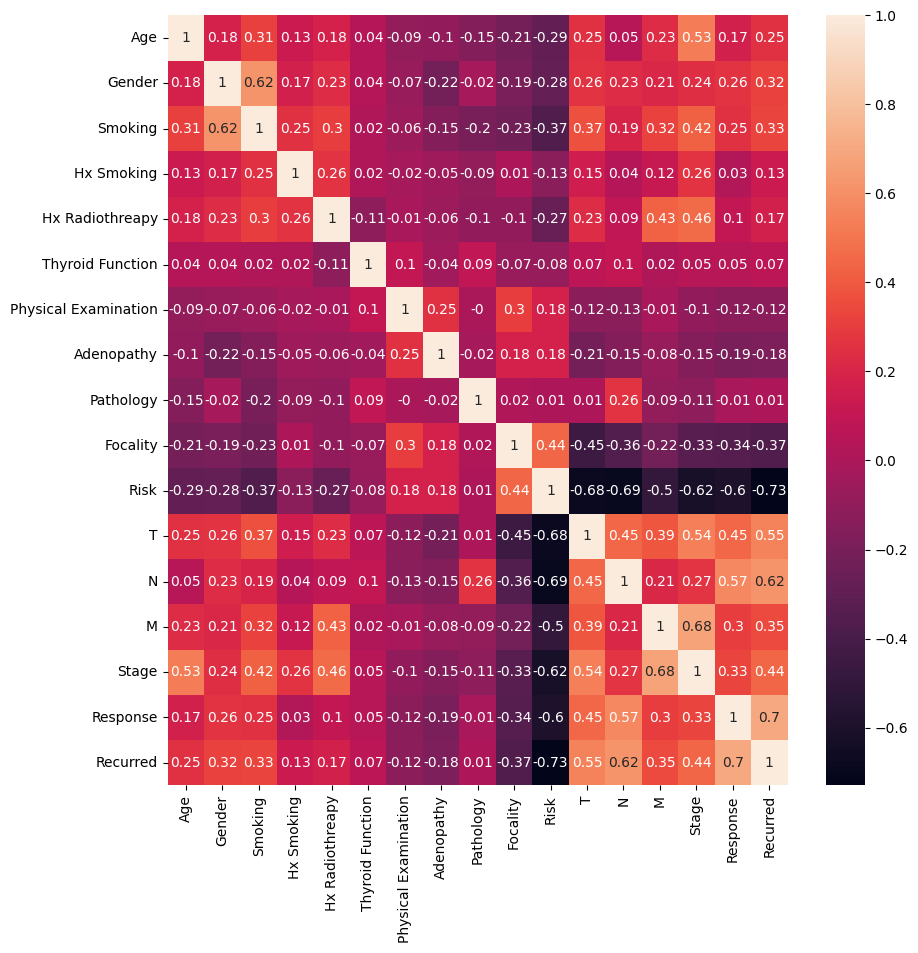

In [3]:
# Calaculate the correlation matrix
corr_matrix = df.corr().round(2)

# Plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [4]:
# show the correlation between features and the target variable (Recurred)
features = corr_matrix['Recurred'].sort_values(ascending=False)
features

Recurred                1.00
Response                0.70
N                       0.62
T                       0.55
Stage                   0.44
M                       0.35
Smoking                 0.33
Gender                  0.32
Age                     0.25
Hx Radiothreapy         0.17
Hx Smoking              0.13
Thyroid Function        0.07
Pathology               0.01
Physical Examination   -0.12
Adenopathy             -0.18
Focality               -0.37
Risk                   -0.73
Name: Recurred, dtype: float64

In [5]:
# Select the features with correlation greater than 0.3
selected_features = features[ (features > 0.3) | (features < -0.3) ]
selected_features

Recurred    1.00
Response    0.70
N           0.62
T           0.55
Stage       0.44
M           0.35
Smoking     0.33
Gender      0.32
Focality   -0.37
Risk       -0.73
Name: Recurred, dtype: float64

In [6]:
selected_features_names = selected_features.index
selected_features_names

Index(['Recurred', 'Response', 'N', 'T', 'Stage', 'M', 'Smoking', 'Gender',
       'Focality', 'Risk'],
      dtype='object')

## Define the features and target variable

In [7]:
df = df[selected_features_names]

X = df.drop('Recurred',axis=1)
y = df['Recurred']

## Split the data into training and testing sets

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Hyperparameter Tuning of an SVM Model with a Pipeline and GridSearchCV

In [9]:
# Create a pipeline with scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear']
}

# Set up cross-validation with GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=3, n_jobs=-1)


## Fit the model

In [10]:

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['rbf', 'linear']},
             verbose=3)

## Calculate the accuracy of the model

In [11]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predictions and evaluation on the train and test set
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)*100:.2f}%")

Train Accuracy: 96.06%
Test Accuracy: 97.27%


## Calculate the confusion matrix for the test set

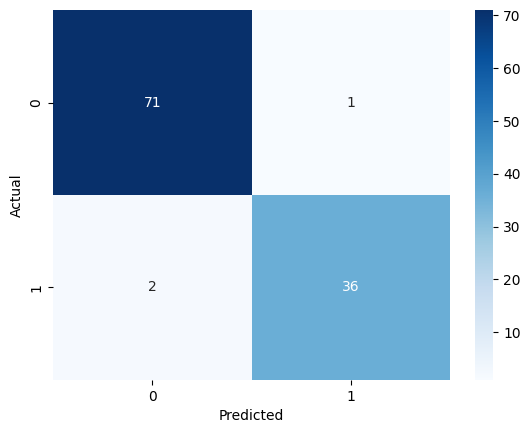

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Calculate sensitivity and specificity

In [13]:
tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

Sensitivity: 0.95
Specificity: 0.99


## Calculate AUC

In [14]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {roc_auc:.2f}')

AUC: 0.99


# Plot the ROC curve

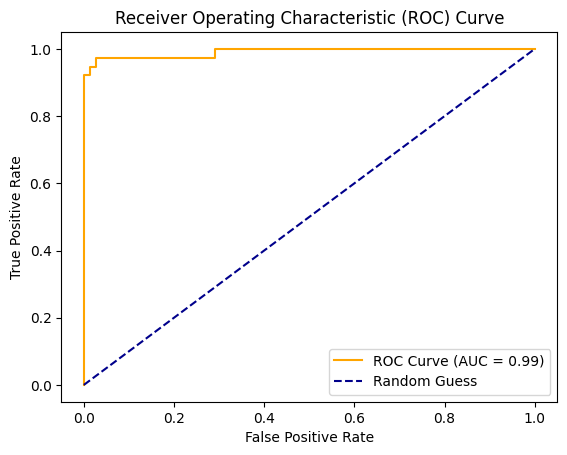

In [15]:
# plot the AUC-ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()

## Save the model

In [16]:
import pickle

with open('saved_models/SVM_model.pkl', 'wb') as model_file:
    pickle.dump(grid_search, model_file)